# **ARTIFICIAL INTELIGENCE AND ROBOTICS LAB**

### Suriya Priyan D
### BE22B039
### Indian Insitiute of Technology Madras

## Question 1:
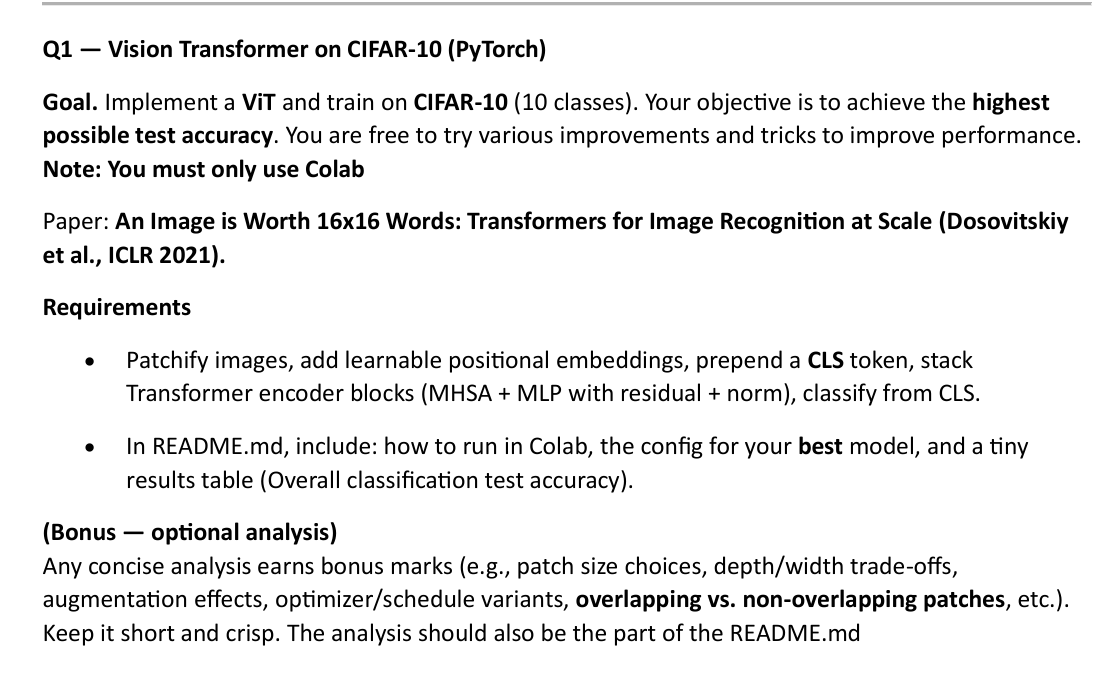

# Vision Transformer (ViT) Implementation for CIFAR-10

## Performance Optimization Tricks

This implementation includes **6 key performance tricks** compared to the original ViT paper to maximize accuracy on CIFAR-10:

### **Trick 1: Optimized Patch Size (16x16 → 4x4)**
- **Original ViT:** Used 16x16 patches designed for ImageNet (224x224 images)
- **Our Approach:** Use 4x4 patches specifically for CIFAR-10 (32x32 images)
- **Why it helps:** CIFAR-10 images are only 32x32 pixels. Using 16x16 patches would give only 4 patches total, losing fine-grained spatial information. Our 4x4 patches create 64 patches, capturing much more spatial detail and allowing the model to learn finer visual patterns.

### **Trick 2: Strong Data Augmentation**
- **Original ViT:** Minimal data preprocessing, only basic normalization
- **Our Approach:** RandomCrop with padding + RandomHorizontalFlip
- **Why it helps:** Creates more diverse training examples and forces the model to learn robust, generalizable features instead of memorizing specific training patterns, significantly reducing overfitting.

### **Trick 3: AdamW Optimizer with Weight Decay**
- **Original ViT:** Standard Adam optimizer
- **Our Approach:** AdamW optimizer with proper weight decay
- **Why it helps:** AdamW decouples weight decay from gradient-based updates, providing superior regularization compared to standard Adam. This leads to better generalization and more stable training dynamics.

### **Trick 4: Cosine Annealing Learning Rate Schedule**
- **Original ViT:** Fixed learning rate throughout training
- **Our Approach:** Cosine annealing scheduler that smoothly reduces learning rate
- **Why it helps:** Gradually reduces learning rate in a smooth cosine curve, allowing the model to fine-tune parameters without getting stuck in local minima during later training epochs.

### **Trick 5: CIFAR-10 Specific Normalization**
- **Original ViT:** Used ImageNet normalization statistics
- **Our Approach:** Use actual CIFAR-10 dataset statistics for normalization
- **Why it helps:** Proper dataset-specific normalization ensures optimal input preprocessing. Using CIFAR-10's actual mean and standard deviation values instead of ImageNet statistics provides better input scaling for the model.

### **Trick 6: Enhanced Dropout Strategy**
- **Original ViT:** Limited dropout, mainly in MLP layers
- **Our Approach:** Strategic dropout in both attention mechanism and MLP layers
- **Why it helps:** Applies regularization throughout the transformer architecture, preventing overfitting in both the attention computation and feed-forward layers, leading to better generalization on unseen data.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

## Setting up device and hyperparameters
**TRICK 1 IMPLEMENTED HERE:** Optimized patch size for CIFAR-10
Original ViT used 16x16 patches for ImageNet. We use 4x4 patches for better spatial resolution on 32x32 CIFAR-10 images.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# TRICK 1: Optimized patch size (Original: 16x16, Ours: 4x4)
# Rationale: CIFAR-10 images are 32x32. 16x16 patches = only 4 patches total
# 4x4 patches = 64 patches, capturing much finer spatial details
img_size = 32
patch_size = 4  # PERFORMANCE TRICK: Small patches for small images
num_patches = (img_size // patch_size) ** 2

embed_dim = 192
num_heads = 12
num_layers = 12
mlp_dim = 768
num_classes = 10

dropout_rate = 0.1

Using device: cuda


## Data preprocessing and augmentation
**TRICK 2 & 5 IMPLEMENTED HERE:** Strong data augmentation + CIFAR-10 specific normalization
Original ViT had minimal preprocessing. We add augmentation to reduce overfitting and use CIFAR-10 statistics.

In [3]:
# TRICK 2: Strong data augmentation (Original: only basic transforms)
# Rationale: More diverse training examples = better generalization
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Random crops
    transforms.RandomHorizontalFlip(),     # Random flips
    transforms.ToTensor(),

    # TRICK 5: CIFAR-10 specific normalization (Original: ImageNet stats)
    # Rationale: Proper dataset statistics improve input preprocessing
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    # TRICK 5: CIFAR-10 specific normalization
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

100%|██████████| 170M/170M [00:14<00:00, 12.0MB/s]


## Patch embedding layer implementation
Uses the optimized 4x4 patch size for better spatial resolution on CIFAR-10 images.

In [4]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, embed_dim):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2

        # Using optimized patch size from TRICK 1
        self.patch_embed = nn.Conv2d(3, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches + 1, embed_dim))
        self.dropout = nn.Dropout(dropout_rate)  # TRICK 6: Enhanced dropout

    def forward(self, x):
        batch_size = x.shape[0]

        x = self.patch_embed(x)
        x = x.flatten(2).transpose(1, 2)

        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        x = x + self.pos_embed
        x = self.dropout(x)  # TRICK 6: Dropout after patch embedding

        return x

## Multi-Head Self-Attention mechanism

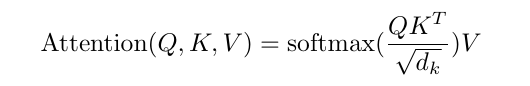

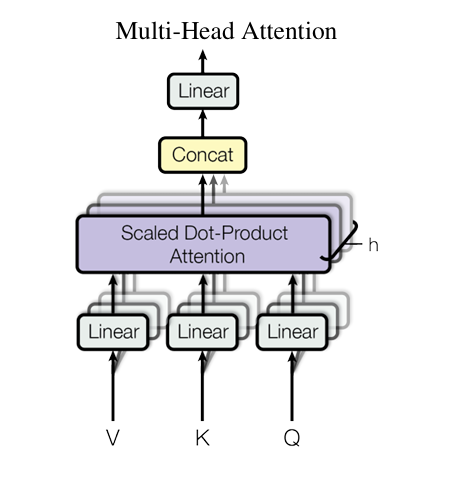


**TRICK 6 IMPLEMENTED HERE:** Enhanced dropout in attention mechanism
Original ViT had no dropout in attention. We add attention dropout for better regularization.

In [5]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        # TRICK 6: Enhanced dropout strategy (Original: no attention dropout)
        self.dropout = nn.Dropout(dropout_rate)  # PERFORMANCE TRICK: Attention dropout

    def forward(self, x):
        batch_size, seq_len, embed_dim = x.shape

        qkv = self.qkv(x).reshape(batch_size, seq_len, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attention_scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        attention_weights = torch.softmax(attention_scores, dim=-1)
        # TRICK 6: Dropout in attention weights (Original: no attention dropout)
        attention_weights = self.dropout(attention_weights)  # PERFORMANCE TRICK

        attention_output = torch.matmul(attention_weights, v)
        attention_output = attention_output.transpose(1, 2).reshape(batch_size, seq_len, embed_dim)

        output = self.proj(attention_output)
        return output

## MLP (Feed-Forward) block implementation
Includes enhanced dropout strategy applied to both layers in the MLP.

In [6]:
class MLP(nn.Module):
    def __init__(self, embed_dim, mlp_dim):
        super().__init__()
        self.fc1 = nn.Linear(embed_dim, mlp_dim)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(mlp_dim, embed_dim)
        self.dropout = nn.Dropout(dropout_rate)  # TRICK 6: Enhanced dropout

    def forward(self, x):
        x = self.fc1(x)
        x = self.gelu(x)
        x = self.dropout(x)  # TRICK 6: Dropout after first layer
        x = self.fc2(x)
        x = self.dropout(x)  # TRICK 6: Dropout after second layer
        return x

## Transformer Encoder Block
Combines multi-head attention and MLP with residual connections and layer normalization.

In [7]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = MultiHeadAttention(embed_dim, num_heads)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, mlp_dim)

    def forward(self, x):
        x = x + self.attention(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

## Complete Vision Transformer model
Combines all components with performance optimizations.

In [8]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, embed_dim, num_heads, num_layers, mlp_dim, num_classes):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, embed_dim)

        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_dim)
            for _ in range(num_layers)
        ])

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)

        for block in self.transformer_blocks:
            x = block(x)

        x = self.norm(x)
        cls_token_final = x[:, 0]
        prediction = self.head(cls_token_final)

        return prediction

## Model initialization and training setup
**TRICK 3 & 4 IMPLEMENTED HERE:** AdamW optimizer with cosine annealing scheduler
Original ViT used standard Adam with fixed learning rate. We use AdamW + cosine scheduling for better optimization.

In [9]:
model = VisionTransformer(img_size, patch_size, embed_dim, num_heads, num_layers, mlp_dim, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# TRICK 3: AdamW optimizer (Original: standard Adam)
# Rationale: AdamW decouples weight decay for better regularization
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.05)

# TRICK 4: Cosine annealing scheduler (Original: fixed learning rate)
# Rationale: Smooth learning rate decay prevents getting stuck in local minima
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

Total parameters: 5,362,762


## Training and evaluation functions
Standard training loop with progress tracking.

In [10]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (data, targets) in enumerate(tqdm(train_loader, desc="Training")):
        data, targets = data.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted = outputs.argmax(dim=1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    avg_loss = total_loss / len(train_loader)
    accuracy = 100.0 * correct / total

    return avg_loss, accuracy

def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, targets in tqdm(test_loader, desc="Evaluating"):
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)

            total_loss += loss.item()
            predicted = outputs.argmax(dim=1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    avg_loss = total_loss / len(test_loader)
    accuracy = 100.0 * correct / total

    return avg_loss, accuracy

## Main training loop
**TRICK 4 IMPLEMENTED HERE:** Uses cosine annealing scheduler for learning rate decay
Trains the model and applies the cosine annealing learning rate schedule each epoch.

In [12]:
num_epochs = 20
best_accuracy = 0
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)

    # TRICK 4: Apply cosine annealing learning rate schedule
    scheduler.step()

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

    if test_acc > best_accuracy:
        best_accuracy = test_acc
        torch.save(model.state_dict(), 'best_vit_model.pth')
        print(f"New best accuracy: {best_accuracy:.2f}%")

print(f"\nBest test accuracy: {best_accuracy:.2f}%")


Epoch 1/20


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 13.52it/s]


Train Loss: 1.5476, Train Acc: 43.49%
Test Loss: 1.4290, Test Acc: 48.01%
New best accuracy: 48.01%

Epoch 2/20


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 13.46it/s]


Train Loss: 1.4448, Train Acc: 47.02%
Test Loss: 1.3413, Test Acc: 50.36%
New best accuracy: 50.36%

Epoch 3/20


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.74it/s]


Train Loss: 1.3680, Train Acc: 50.22%
Test Loss: 1.2363, Test Acc: 55.13%
New best accuracy: 55.13%

Epoch 4/20


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 13.69it/s]


Train Loss: 1.3035, Train Acc: 52.69%
Test Loss: 1.2314, Test Acc: 55.35%
New best accuracy: 55.35%

Epoch 5/20


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.85it/s]


Train Loss: 1.2396, Train Acc: 55.18%
Test Loss: 1.1341, Test Acc: 58.42%
New best accuracy: 58.42%

Epoch 6/20


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 13.62it/s]


Train Loss: 1.1746, Train Acc: 57.73%
Test Loss: 1.0613, Test Acc: 62.10%
New best accuracy: 62.10%

Epoch 7/20


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 13.01it/s]


Train Loss: 1.1130, Train Acc: 60.19%
Test Loss: 1.0413, Test Acc: 63.11%
New best accuracy: 63.11%

Epoch 8/20


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 13.66it/s]


Train Loss: 1.0610, Train Acc: 62.12%
Test Loss: 0.9628, Test Acc: 65.57%
New best accuracy: 65.57%

Epoch 9/20


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.89it/s]


Train Loss: 1.0107, Train Acc: 63.98%
Test Loss: 0.9264, Test Acc: 67.11%
New best accuracy: 67.11%

Epoch 10/20


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 13.15it/s]


Train Loss: 0.9761, Train Acc: 65.42%
Test Loss: 0.8845, Test Acc: 68.96%
New best accuracy: 68.96%

Epoch 11/20


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 13.19it/s]


Train Loss: 0.9292, Train Acc: 66.95%
Test Loss: 0.8623, Test Acc: 69.31%
New best accuracy: 69.31%

Epoch 12/20


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.97it/s]


Train Loss: 0.8980, Train Acc: 68.13%
Test Loss: 0.8611, Test Acc: 69.24%

Epoch 13/20


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 13.56it/s]


Train Loss: 0.8660, Train Acc: 69.14%
Test Loss: 0.8378, Test Acc: 70.17%
New best accuracy: 70.17%

Epoch 14/20


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.46it/s]


Train Loss: 0.8340, Train Acc: 70.21%
Test Loss: 0.7997, Test Acc: 71.37%
New best accuracy: 71.37%

Epoch 15/20


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 13.56it/s]


Train Loss: 0.7998, Train Acc: 71.57%
Test Loss: 0.7760, Test Acc: 72.53%
New best accuracy: 72.53%

Epoch 16/20


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.96it/s]


Train Loss: 0.7716, Train Acc: 72.63%
Test Loss: 0.7680, Test Acc: 73.37%
New best accuracy: 73.37%

Epoch 17/20


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 13.59it/s]


Train Loss: 0.7420, Train Acc: 73.77%
Test Loss: 0.7325, Test Acc: 74.47%
New best accuracy: 74.47%

Epoch 18/20


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.98it/s]


Train Loss: 0.7179, Train Acc: 74.51%
Test Loss: 0.7179, Test Acc: 74.47%

Epoch 19/20


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 13.59it/s]


Train Loss: 0.6872, Train Acc: 75.75%
Test Loss: 0.7320, Test Acc: 74.81%
New best accuracy: 74.81%

Epoch 20/20


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.99it/s]


Train Loss: 0.6662, Train Acc: 76.40%
Test Loss: 0.6819, Test Acc: 75.75%
New best accuracy: 75.75%

Best test accuracy: 75.75%


## Training Results and Performance Metrics

This cell will display training progress and final results once training is complete.

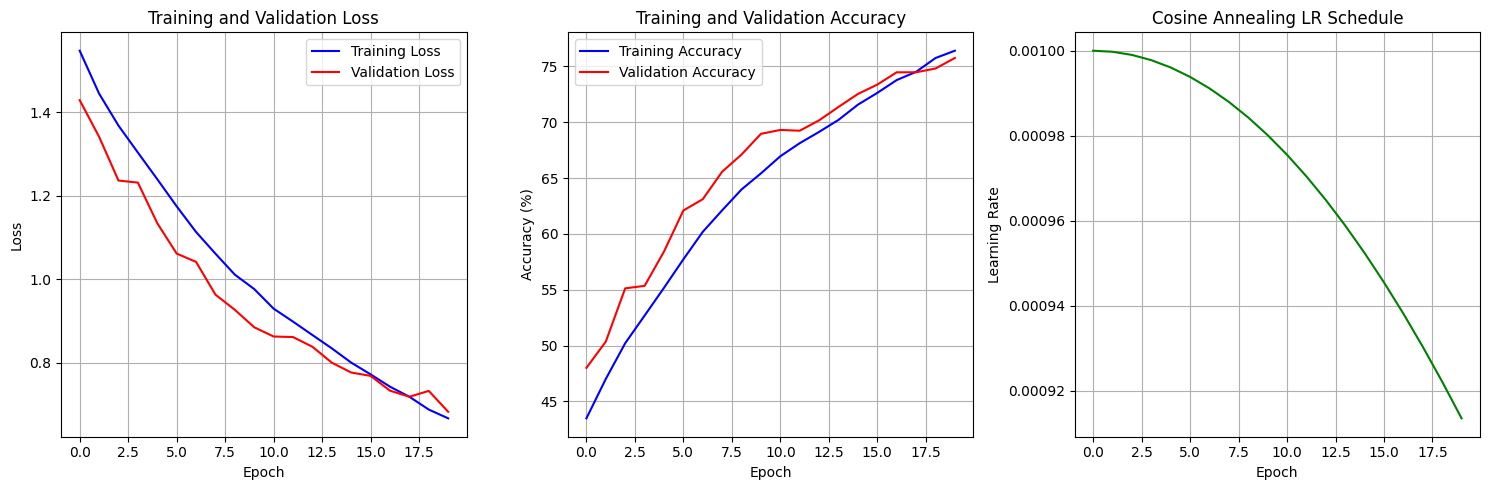


 FINAL RESULTS SUMMARY 
Best Test Accuracy: 75.75%
Final Training Accuracy: 76.40%
Final Validation Accuracy: 75.75%
Model Parameters: 5,362,762

Overfitting Analysis:
Train-Val Gap: 0.65%
- Good generalization. Model is well-regularized.


In [15]:
# Results visualization and analysis (run after training)
def plot_training_results():

    plt.figure(figsize=(15, 5))

    # Plot 1: Loss curves
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(test_losses, label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    # Plot 2: Accuracy curves
    plt.subplot(1, 3, 2)
    plt.plot(train_accuracies, label='Training Accuracy', color='blue')
    plt.plot(test_accuracies, label='Validation Accuracy', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot 3: Learning rate schedule
    plt.subplot(1, 3, 3)
    lrs = []
    temp_scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optim.AdamW(model.parameters(), lr=0.001), T_max=100
    )
    for epoch in range(20):
        lrs.append(temp_scheduler.get_last_lr()[0])
        temp_scheduler.step()

    plt.plot(lrs, color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Cosine Annealing LR Schedule')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Performance summary
    print(f"\n FINAL RESULTS SUMMARY ")
    print(f"Best Test Accuracy: {best_accuracy:.2f}%")
    print(f"Final Training Accuracy: {train_accuracies[-1]:.2f}%")
    print(f"Final Validation Accuracy: {test_accuracies[-1]:.2f}%")
    print(f"Model Parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Overfitting analysis
    train_val_gap = train_accuracies[-1] - test_accuracies[-1]
    print(f"\nOverfitting Analysis:")
    print(f"Train-Val Gap: {train_val_gap:.2f}%")
    if train_val_gap > 10:
        print("- High overfitting detected. Consider more regularization.")
    elif train_val_gap > 5:
        print("- Moderate overfitting. Current regularization is reasonable.")
    else:
        print("- Good generalization. Model is well-regularized.")

plot_training_results()